In [2]:
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [3]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']

# load library

In [1]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# original library
sys.path.append('../../')
import common as com
import pytorch_modeler as modeler

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# ML lib
import scipy
from scipy.stats import zscore
#from umap import UMAP
from sklearn.mixture import GaussianMixture
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis


import librosa
import IPython
import librosa.display

# load config and set logger

In [4]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/eval{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '01_eval.py')

# Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet/dcase2021_task2/config.yaml'

# load data

In [7]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [8]:
data_types = ['train', 'dev_test']

In [9]:
def load_ext_data(machine_type):
    input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    ext_data = pd.read_pickle(input_path)
    
    return ext_data

In [10]:
def load_ext_test_data(machine_type):
    input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features_test.pkl'
    ext_data = pd.read_pickle(input_path)
    
    return ext_data

In [11]:
# for train datasets
def get_target_names(wav_names):
    target_names = []
    for wav_name in wav_names:
        if 'target' in wav_name:
            target_names.append(wav_name)
    
    return target_names

# evaluation

## calc MVG (multivariate Gaussian)

In [12]:
com.tic()

MVG = {}
for machine_type in machine_types:
    MVG[machine_type] = {}
    ext_data = load_ext_data(machine_type)
    
    mean = ext_data['train']['features'].mean(axis=0)
    I = np.identity(ext_data['train']['features'].shape[1])
    cov = np.cov(ext_data['train']['features'], rowvar=False) + 0.01 * I
    MVG[machine_type]['mean'] = mean
    MVG[machine_type]['cov'] = cov

com.toc()

elapsed time: 4.049314737 [sec]


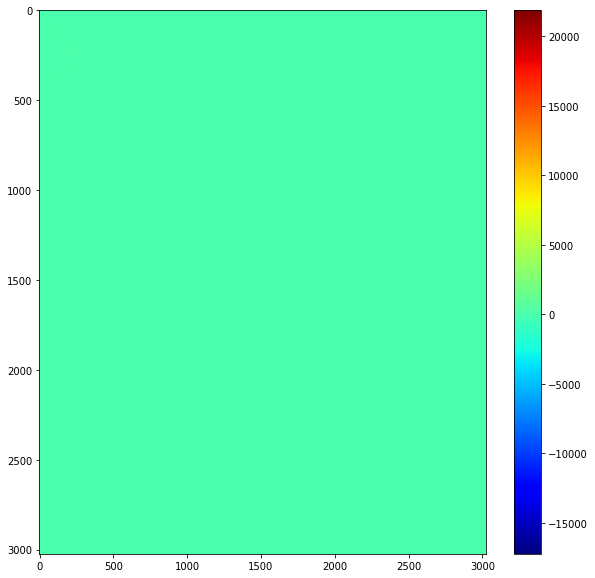

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(MVG[machine_types[0]]['cov'], aspect='auto', cmap='jet')
plt.colorbar()
plt.show()

## estimate

In [14]:
def calc_mahalanobis(mean, cov, samples):
    cov_inv = np.linalg.inv(MVG[machine_type]['cov'])
    # load data
    dists = [mahalanobis(sample, mean, cov_inv) for sample in samples]
    # np.array
    dists = np.array(dists)
    return dists

In [15]:
from IPython.display import display

In [16]:
def get_score_perID(describe_df, max_fpr=0.1):
    # ユニークsectionを取得、昇順ソート
    sections = np.sort(describe_df['section_types'].unique())

    for section in sections:
        per_section_df = describe_df[describe_df['section_types'] == section]
        per_section_AUC = roc_auc_score(per_section_df['labels'], per_section_df['preds'])
        per_section_pAUC = roc_auc_score(per_section_df['labels'], per_section_df['preds'], max_fpr=max_fpr)
        # column = [AUC,pAUC], row = index
        score_df = pd.DataFrame(np.stack([per_section_AUC, per_section_pAUC]), index=['AUC', 'pAUC']).T
        # indexをsectionナンバーにrename
        # column = [AUC,pAUC], row = [section]
        score_df.index = [section]
        if section == 0:
            scores_df = score_df.copy()
        else:
            # 結合
            scores_df = scores_df.append(score_df)
    return scores_df

## Calc Score

In [19]:
for i, machine_type in enumerate(machine_types):
    logger.info('CALC SCORE')
    logger.info(machine_type)
    # get MVG
    tr_mean = MVG[machine_type]['mean']
    tr_cov = MVG[machine_type]['cov']
    # load samples
    ext_data = load_ext_data(machine_type)
    for phase in ['valid_source', 'valid_target']:
        # pred
        samples = ext_data[phase]['features']
        preds = calc_mahalanobis(tr_mean, tr_cov, samples)
        section_types = com.get_section_types(ext_data[phase]['wav_names'])
        # wavname + pred
        preds_pd = np.stack([np.array(ext_data[phase]['wav_names']), preds], axis=1)
        preds_pd = pd.DataFrame(preds_pd, columns=['wav_name', 'pred'])
        preds_pd.to_csv(OUT_PRED_DIR + f'/pred_{machine_type}_{phase}.csv')
        # dataframe作成
        describe_df = com.get_pred_discribe(labels=ext_data[phase]['labels'],
                                            preds=preds,
                                            section_types=section_types,
                                            wav_names=ext_data[phase]['wav_names'])
        # スコア算出(AUC, pAUC)
        scores_df = com.get_score_per_Section(describe_df, max_fpr=0.1)

        # 結合(source + target)
        scores_df = scores_df.rename(index=lambda num: 'id_0' + f'{num}')
        all_scores_df = scores_df.copy()
            
    # 平均
    mean_df = pd.DataFrame(all_scores_df.mean(axis=0)).T
    mean_df.index = ['mean']
    # 調和平均
    hmean = scipy.stats.hmean(all_scores_df, axis=0)
    hmean_df = pd.DataFrame(hmean, index=['AUC', 'pAUC']).T
    hmean_df.index = ['h_mean']
    # 結合
    all_scores_df = all_scores_df.append(mean_df)
    all_scores_df = all_scores_df.append(hmean_df)
    # 出力
    all_scores_df.to_csv(f'{OUT_SCORE_DIR}/{machine_type}_score.csv')
    # display
    display(all_scores_df)

2021-08-10 20:26:37,582 - 01_eval.py - INFO - CALC SCORE
2021-08-10 20:26:37,583 - 01_eval.py - INFO - fan


,AUC,pAUC
id_00,0.463600,0.516316
id_01,0.530300,0.504211
id_02,0.603700,0.525263
mean,0.532533,0.515263
h_mean,0.526389,0.515118


2021-08-10 20:26:44,867 - 01_eval.py - INFO - CALC SCORE
2021-08-10 20:26:44,868 - 01_eval.py - INFO - gearbox


,AUC,pAUC
id_00,0.596161,0.497340
id_01,0.461677,0.484604
id_02,0.484206,0.483500
mean,0.514015,0.488481
h_mean,0.507730,0.488401


2021-08-10 20:26:52,452 - 01_eval.py - INFO - CALC SCORE
2021-08-10 20:26:52,453 - 01_eval.py - INFO - pump


,AUC,pAUC
id_00,0.521100,0.483158
id_01,0.536200,0.503158
id_02,0.508000,0.504211
mean,0.521767,0.496842
h_mean,0.521513,0.496651


2021-08-10 20:26:59,164 - 01_eval.py - INFO - CALC SCORE
2021-08-10 20:26:59,165 - 01_eval.py - INFO - slider


,AUC,pAUC
id_00,0.578900,0.502105
id_01,0.451224,0.477229
id_02,0.545079,0.500799
mean,0.525068,0.493378
h_mean,0.519193,0.493109


2021-08-10 20:27:07,437 - 01_eval.py - INFO - CALC SCORE
2021-08-10 20:27:07,449 - 01_eval.py - INFO - ToyCar


,AUC,pAUC
id_00,0.545400,0.505263
id_01,0.453400,0.483684
id_02,0.456800,0.516842
mean,0.485200,0.501930
h_mean,0.481679,0.501550


2021-08-10 20:27:16,786 - 01_eval.py - INFO - CALC SCORE
2021-08-10 20:27:16,788 - 01_eval.py - INFO - ToyTrain


,AUC,pAUC
id_00,0.475600,0.484211
id_01,0.507400,0.508421
id_02,0.520900,0.511579
mean,0.501300,0.501404
h_mean,0.500568,0.501100


2021-08-10 20:27:23,447 - 01_eval.py - INFO - CALC SCORE
2021-08-10 20:27:23,448 - 01_eval.py - INFO - valve


,AUC,pAUC
id_00,0.466800,0.493684
id_01,0.467700,0.486842
id_02,0.463000,0.483158
mean,0.465833,0.487895
h_mean,0.465824,0.487856


In [20]:
for i, machine_type in enumerate(machine_types):
    logger.info('CALC SCORE')
    logger.info(machine_type)
    # get MVG
    tr_mean = MVG[machine_type]['mean']
    tr_cov = MVG[machine_type]['cov']
    # load samples
    ext_data = load_ext_test_data(machine_type)
    for phase in ['eval_test']:
        # pred
        samples = ext_data[phase]['features']
        preds = calc_mahalanobis(tr_mean, tr_cov, samples)
        section_types = com.get_id(ext_data[phase]['wav_names'])
        # wavname + pred
        preds_pd = np.stack([preds, section_types, np.array(ext_data[phase]['wav_names'])], axis=1)
        preds_pd = pd.DataFrame(preds_pd, columns=['preds', 'section_types', 'wav_names'])
        preds_pd.to_csv(OUT_PRED_DIR + f'/pred_{machine_type}_{phase}.csv')
        # dataframe作成
#         describe_df = com.get_pred_discribe(labels=ext_data[phase]['labels'],
#                                             preds=preds,
#                                             section_types=section_types,
#                                             wav_names=ext_data[phase]['wav_names'])
#         # スコア算出(AUC, pAUC)
#         scores_df = com.get_score_per_Section(describe_df, max_fpr=0.1)

#         # 結合(source + target)
#         scores_df = scores_df.rename(index=lambda num: 'id_0' + f'{num}')
#         all_scores_df = scores_df.copy()
            
#     # 平均
#     mean_df = pd.DataFrame(all_scores_df.mean(axis=0)).T
#     mean_df.index = ['mean']
#     # 調和平均
#     hmean = scipy.stats.hmean(all_scores_df, axis=0)
#     hmean_df = pd.DataFrame(hmean, index=['AUC', 'pAUC']).T
#     hmean_df.index = ['h_mean']
#     # 結合
#     all_scores_df = all_scores_df.append(mean_df)
#     all_scores_df = all_scores_df.append(hmean_df)
#     # 出力
#     all_scores_df.to_csv(f'{OUT_SCORE_DIR}/{machine_type}_score.csv')
#     # display
#     display(all_scores_df)

2021-07-16 16:39:05,328 - 01_eval.py - INFO - CALC SCORE
2021-07-16 16:39:05,329 - 01_eval.py - INFO - fan
2021-07-16 16:39:15,219 - 01_eval.py - INFO - CALC SCORE
2021-07-16 16:39:15,220 - 01_eval.py - INFO - pump
2021-07-16 16:39:21,859 - 01_eval.py - INFO - CALC SCORE
2021-07-16 16:39:21,860 - 01_eval.py - INFO - slider
2021-07-16 16:39:28,287 - 01_eval.py - INFO - CALC SCORE
2021-07-16 16:39:28,289 - 01_eval.py - INFO - ToyCar
2021-07-16 16:39:39,678 - 01_eval.py - INFO - CALC SCORE
2021-07-16 16:39:39,679 - 01_eval.py - INFO - ToyConveyor
2021-07-16 16:39:51,866 - 01_eval.py - INFO - CALC SCORE
2021-07-16 16:39:51,867 - 01_eval.py - INFO - valve


2021-08-10 20:28:43,228 - 01_eval.py - INFO - fan valid_source AUC : 0.5368222222222222
2021-08-10 20:28:43,232 - 01_eval.py - INFO - fan valid_target AUC : 0.5257555555555555


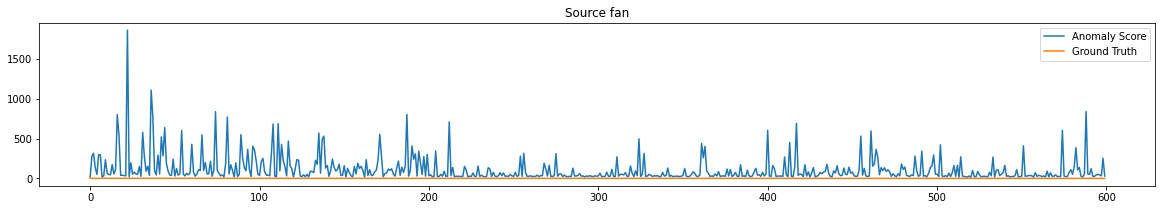

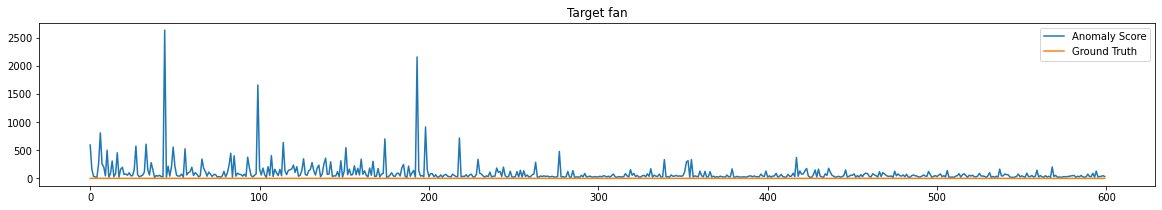

2021-08-10 20:28:50,507 - 01_eval.py - INFO - gearbox valid_source AUC : 0.5107894718600314
2021-08-10 20:28:50,510 - 01_eval.py - INFO - gearbox valid_target AUC : 0.5150254276467868


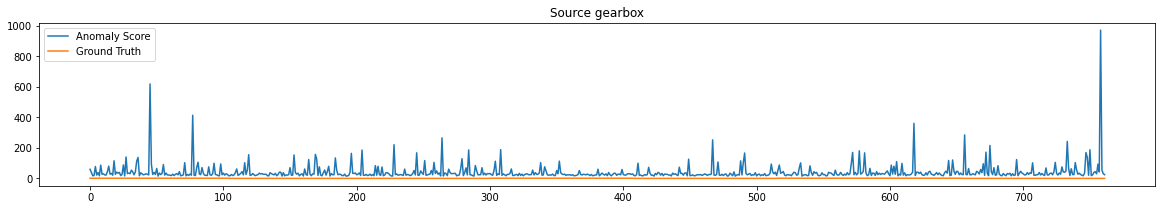

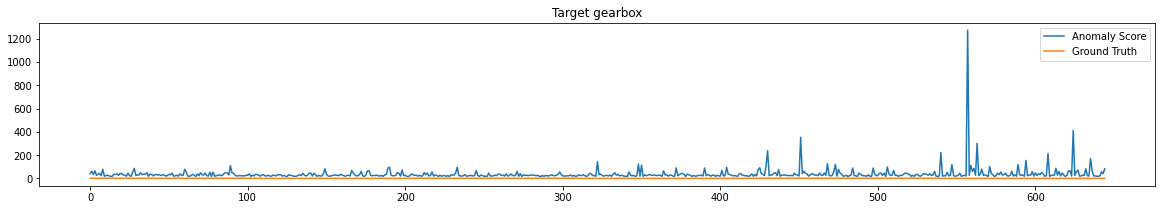

2021-08-10 20:28:56,595 - 01_eval.py - INFO - pump valid_source AUC : 0.45467777777777785
2021-08-10 20:28:56,597 - 01_eval.py - INFO - pump valid_target AUC : 0.5068555555555556


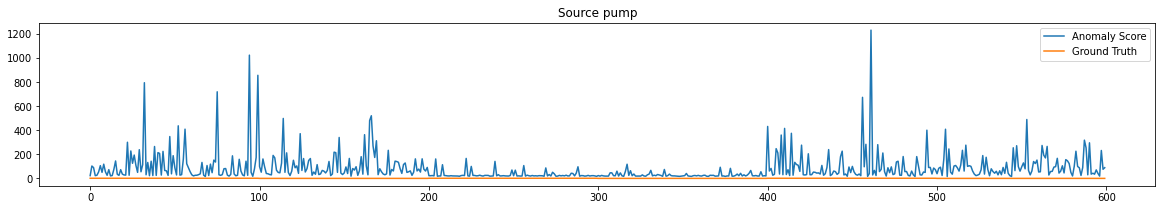

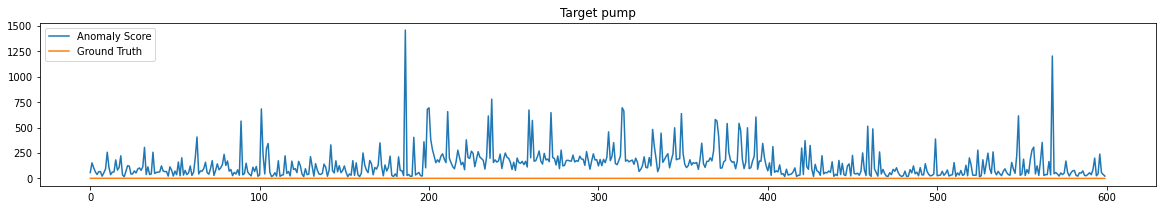

2021-08-10 20:29:02,505 - 01_eval.py - INFO - slider valid_source AUC : 0.518329416791284
2021-08-10 20:29:02,508 - 01_eval.py - INFO - slider valid_target AUC : 0.5281898454746137


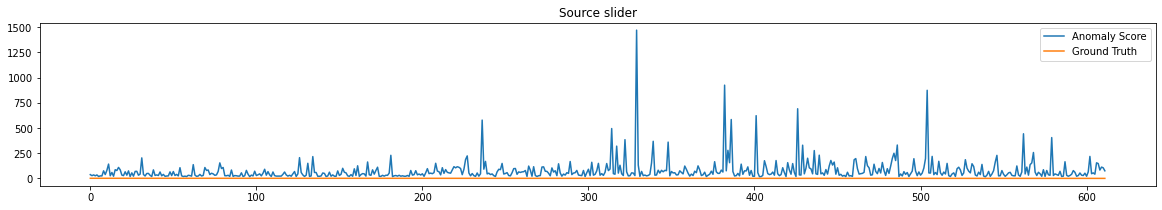

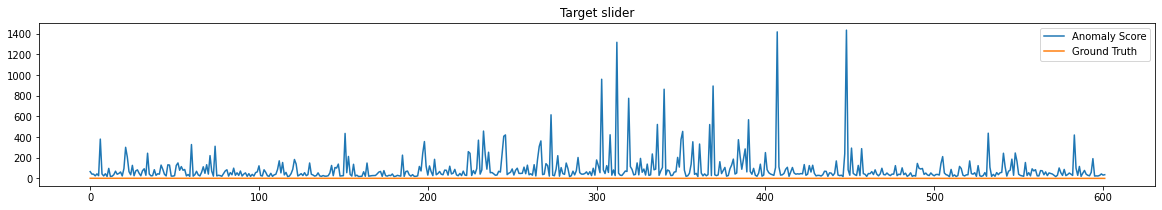

2021-08-10 20:29:11,522 - 01_eval.py - INFO - ToyCar valid_source AUC : 0.5385222222222222
2021-08-10 20:29:11,525 - 01_eval.py - INFO - ToyCar valid_target AUC : 0.4877666666666667


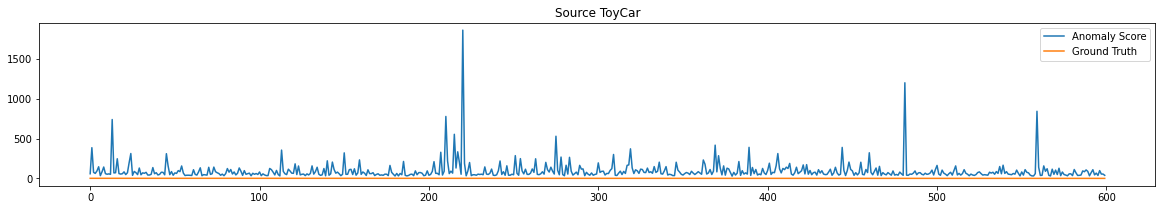

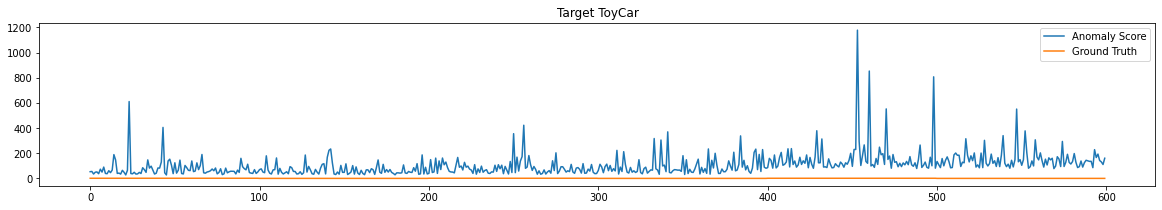

2021-08-10 20:29:17,638 - 01_eval.py - INFO - ToyTrain valid_source AUC : 0.5592222222222223
2021-08-10 20:29:17,643 - 01_eval.py - INFO - ToyTrain valid_target AUC : 0.48921111111111115


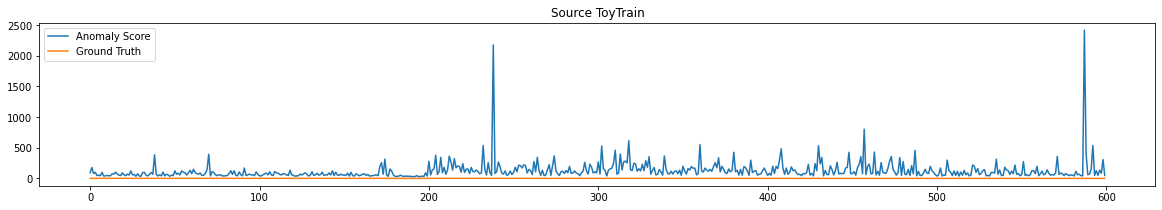

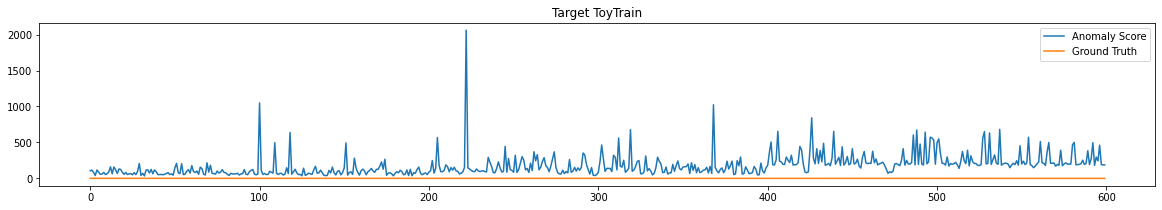

2021-08-10 20:29:23,619 - 01_eval.py - INFO - valve valid_source AUC : 0.503
2021-08-10 20:29:23,622 - 01_eval.py - INFO - valve valid_target AUC : 0.46743333333333326


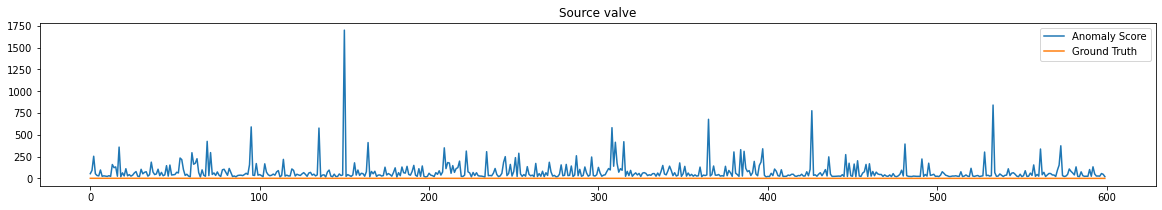

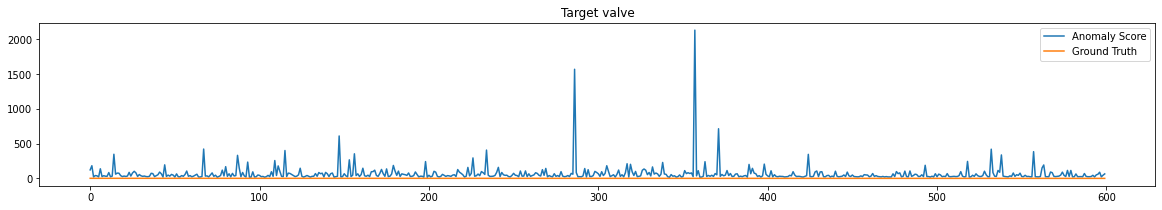

In [21]:
preds = calc_mahalanobis(tr_mean, tr_cov, samples)
for machine_type in machine_types:
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = np.linalg.inv(MVG[machine_type]['cov'])
    # load data
    ext_data = load_ext_data(machine_type)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')
    
    plt.figure(figsize=(20,3))
    plt.title(f'Source {machine_type}')
    plt.plot(valid_source_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_source']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(20,3))
    plt.title(f'Target {machine_type}')
    plt.plot(valid_target_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_target']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()

## calc GMM

In [22]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [23]:
ext_data = load_ext_data(machine_types[6])
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(ext_data['train']['features'])

GaussianMixture(n_components=3, random_state=42)

In [24]:
gmm.bic(ext_data['train']['features'])

82929910.37079072

In [25]:
pred = gmm.predict(ext_data['train']['features'])

(array([ 865.,    0.,    0.,    0.,    0., 4795.,    0.,    0.,    0.,
         340.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

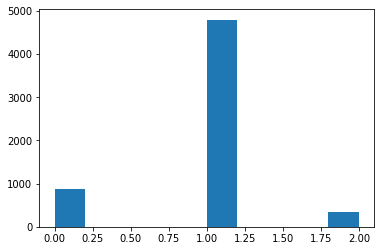

In [26]:
plt.hist(pred)

In [27]:
gmm_covs = gmm.covariances_
gmm_means = gmm.means_

In [28]:
gmm_covs = gmm.covariances_
gmm_means = gmm.means_


# calc mahalanobis (Anomaly Score)
valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]

In [29]:
for machine_type in machine_types:
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = MVG[machine_type]['cov']
    # load data
    ext_data = load_ext_data(machine_type)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')

2021-08-10 20:31:08,931 - 01_eval.py - INFO - fan valid_source AUC : 0.5199333333333334
2021-08-10 20:31:08,935 - 01_eval.py - INFO - fan valid_target AUC : 0.48635555555555554
2021-08-10 20:31:15,815 - 01_eval.py - INFO - gearbox valid_source AUC : 0.5468768412807343
2021-08-10 20:31:15,829 - 01_eval.py - INFO - gearbox valid_target AUC : 0.5345584835876098
2021-08-10 20:31:20,336 - 01_eval.py - INFO - pump valid_source AUC : 0.5726666666666667
2021-08-10 20:31:20,354 - 01_eval.py - INFO - pump valid_target AUC : 0.46225555555555553
2021-08-10 20:31:24,826 - 01_eval.py - INFO - slider valid_source AUC : 0.4767036957914975
2021-08-10 20:31:24,829 - 01_eval.py - INFO - slider valid_target AUC : 0.49854304635761587
2021-08-10 20:31:29,699 - 01_eval.py - INFO - ToyCar valid_source AUC : 0.5136777777777778
2021-08-10 20:31:29,702 - 01_eval.py - INFO - ToyCar valid_target AUC : 0.4742444444444445
2021-08-10 20:31:34,598 - 01_eval.py - INFO - ToyTrain valid_source AUC : 0.4171
2021-08-10 20:

In [25]:
gmm_section_types = gmm.predict(feats)

NameError: name 'feats' is not defined

In [ ]:
sns.distplot(section_types)

In [ ]:
sns.displot(gmm_section_types)